# Evolutionary Computation Assignment 5

##### Solutions checked by solution checker

- Krzysztof Szala 144571
- Vadym Repetskyi 155610


In [2]:
from utils import TspInstance, random_solution
import numpy as np

# Problem description

The goal of the task is to improve the time efficiency of the steepest local search with the use move
evaluations (deltas) from previous iterations (list of improving moves) using the neighborhood, which
turned out to be the best in assignment 3. Both inter-route and intra-route moves should be included
in the list. In the case of inter-route moves of the exchange of two edges, you should carefully read
the description of the lectures on the traveling salesman problem, in particular:
- Consider 3 situations (when we browse moves from LM):
    - Removed edges (defining the saved move) no longer exist in the current solution (at
    least one of them)
        - -> remove the move from LM
    - Removed edges occur in the current solution in a different relative direction from the
    saved one – not applicable now but the move can be applied in the future
        - -> leave the move in LM but do not apply it browse LM further
    - Removed edges appear in the current solution in the same relative direction (also
    both reversed)
        - -> perform (apply) the move and remove from LM
- When evaluating new moves we need to consider also moves with inverted edges


This mechanism should be used separately from candidate moves. Optionally, you can try to
implement them both together.
As starting solutions use random solutions.
As baseline report also results of the steepest local search with random starting solutions without
these mechanisms.

# Pseudocode 

1. Generate a Random Starting Solution
2. Initialize list of all possible improving moves (move: delta_value, node_1, node_2, move_type, inter_type, removed_edges (after applying that move))
- For inter-node exchanges, consider moves where each node currently outside the cycle is swapped into the position of a node within the cycle.
- For intra-edge exchanges, perform a 2-edge exchange. e.g. If the edges are (1, 2) and (3, 4), reconnect the nodes as (1, 3) and (2, 4).
3. WHILE there are improving moves
- 3.1 Choose the best move -> move which decrease solution cost by the biggest value
- 3.2. Check if the move is still valid depending on the conditions
    - All removed_edges (after applying the move), still exist in our solution
    - If inter-node
        - Node to-select is still outside of a cycle
        - Node to-unselect is still within the cycle
    If these, conditions are met apply the move, otherwise remove it from improving moves list.
- 3.3. After applying best applicable move, add not applicable moves to the improving move list.
- 3.4. If some of removed_edges of some move, it's no longer in our solution, remove the move from our improving move list.
- 3.5. Add new moves, which are possible after applying last move to the list.
4. Return solution

In [3]:
def single_inter_move_v1(tsp, solution, to_unselect, to_select):
    solution = solution.copy()
    insert_index = np.where(solution == to_unselect)[0][0]

    prev = solution[insert_index - 1]
    next = solution[(insert_index + 1) % len(solution)]

    cost_change = (
        tsp.node_costs[to_select]
        + tsp.distance_matrix[prev, to_select]
        + tsp.distance_matrix[to_select, next]
        - tsp.node_costs[to_unselect]
        - tsp.distance_matrix[prev, to_unselect]
        - tsp.distance_matrix[to_unselect, next]
    )

    return cost_change, to_unselect, to_select, "inter"

def single_inter_move(tsp, solution, given_node, to_select, inter_type):
    if inter_type == "next":
        unselect_index = (np.where(solution == given_node)[0][0] + 1) % len(solution)
        to_unselect = solution[unselect_index]
        cost_change, to_unselect, to_select, move_type = single_inter_move_v1(tsp, solution, to_unselect, to_select)
    else:
        unselect_index = (np.where(solution == given_node)[0][0] - 1) % len(solution)
        to_unselect = solution[unselect_index]
        cost_change, to_unselect, to_select, move_type = single_inter_move_v1(tsp, solution, to_unselect, to_select)
    
    removed_edges = [(solution[(unselect_index - 1) % len(solution)], to_unselect), (to_unselect, solution[(unselect_index + 1) % len(solution)])]
    added_edges =   [(solution[(unselect_index - 1) % len(solution)], to_select),   (to_select, solution[(unselect_index + 1) % len(solution)])]
    
    removed_edges = tuple(sorted([tuple(map(int, edge)) for edge in removed_edges]))
    added_edges = tuple(sorted([tuple(map(int, edge)) for edge in added_edges]))

    removed_edges = tuple(sorted(removed_edges))
    added_edges = tuple(sorted(added_edges))
    
    cost_change = int(cost_change)
    given_node = int(given_node)
    to_select = int(to_select)
    
    return cost_change, given_node, to_select, move_type, inter_type, removed_edges, added_edges

def apply_inter_move(solution, given_node, to_select, inter_type):
    solution = solution.copy()
    if inter_type == "next":
        unselect_index = (np.where(solution == given_node)[0][0] + 1) % len(solution)
        solution[unselect_index] = to_select
    else:
        unselect_index = (np.where(solution == given_node)[0][0] - 1) % len(solution)
        solution[unselect_index] = to_select
    return solution

In [4]:
def single_intra_move(tsp, solution, a, b, intra_type):
    solution = solution.copy()
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]

    if abs(index_a - index_b) == 1:
        return 0, a, b, "intra"
    
    if intra_type == "next":
        a_next = solution[(index_a + 1) % len(solution)]
        b_next = solution[(index_b + 1) % len(solution)]

        cost_change = (
            tsp.distance_matrix[a, b]
            + tsp.distance_matrix[a_next, b_next]
            - tsp.distance_matrix[a, a_next]
            - tsp.distance_matrix[b, b_next]
        )
        removed_edges = [(solution[index_a], solution[(index_a + 1) % len(solution)]), (solution[index_b], solution[(index_b + 1) % len(solution)])]
        added_edges =   [(solution[index_a], solution[index_b]), (solution[(index_a + 1) % len(solution)], solution[(index_b + 1) % len(solution)])]
    elif intra_type == "prev":
        
        a_prev = solution[(index_a - 1) % len(solution)]
        b_prev = solution[(index_b - 1) % len(solution)]

        cost_change = (
            tsp.distance_matrix[a, b]
            + tsp.distance_matrix[a_prev, b_prev]
            - tsp.distance_matrix[a_prev, a]
            - tsp.distance_matrix[b_prev, b]
        )
        removed_edges = [(solution[(index_a - 1) % len(solution)], solution[index_a]), (solution[(index_b - 1) % len(solution)], solution[index_b])]
        added_edges  =  [(solution[index_a], solution[index_b]), (a_prev,b_prev)]
        
    removed_edges = tuple(([tuple(map(int, edge)) for edge in removed_edges]))
    added_edges   = tuple(([tuple(map(int, edge)) for edge in added_edges]))
    
    removed_edges = tuple(removed_edges)
    added_edges   = tuple(added_edges)
    
    cost_change = int(cost_change)
    a = int(a)
    b = int(b)

    return cost_change, a, b, "intra", intra_type, removed_edges, added_edges

def apply_intra_move(solution, a, b, intra_type):
    index_a = np.where(solution == a)[0][0]
    index_b = np.where(solution == b)[0][0]
    solution = solution.copy()
    if intra_type == "next":
        if index_a < index_b:
            subsequence = solution[(index_a + 1) : index_b + 1][::-1]
            solution[(index_a + 1) : index_b + 1] = subsequence
        else:
            subsequence = solution[(index_b + 1) : index_a + 1][::-1]
            solution[(index_b + 1) : index_a + 1] = subsequence
            
    elif intra_type == "prev":
        if index_a < index_b:
            subsequence = solution[index_a : index_b][::-1]
            solution[index_a : index_b] = subsequence
        else:
            subsequence = solution[index_b : index_a][::-1]
            solution[index_b : index_a] = subsequence
    return solution

In [5]:
def get_k_node_moves(tsp, solution, candidate_list, a):
    closest_vertices = np.argsort(tsp.distance_matrix[a] + tsp.node_costs)
    closest_vertices = closest_vertices[closest_vertices != a][:10]

    for b in closest_vertices:
        if b in solution:
            move_1 = single_intra_move(tsp, solution, a, b, "next")
            move_2 = single_intra_move(tsp, solution, a, b, "prev")
        else:
            move_1 = single_inter_move(tsp, solution, a, b, "next")
            move_2 = single_inter_move(tsp, solution, a, b, "prev")
            
        move_1 = tuple(move_1)
        move_2 = tuple(move_2)

        if move_1[0] < 0:
            candidate_list.append(move_1)
        if move_2[0] < 0:
            candidate_list.append(move_2)
    return candidate_list

def add_new_moves(tsp, solution, candidate_list, move):
    if move[3] == "inter":
        new_node = move[2]
        candidate_list = get_k_node_moves(tsp, solution, candidate_list, new_node)
    elif move[3] == "intra":
        new_edges = move[6]
        for edge in new_edges:
            for x in edge:
                candidate_list = get_k_node_moves(tsp, solution, candidate_list, x)
    return candidate_list

def check_if_applicable(move, all_edges, solution):
    removed_edges = move[5]
    # if any edges to remove is not in all edges, then move is not applicable
    if not all(edge in all_edges for edge in removed_edges):
        return False
    
    if move[3] == "inter":
        to_select = move[2]
        if to_select in solution:
            return False
    
    return True

In [6]:
def delta_method(tsp: TspInstance, start_node: int):
    
    # 1. Generate Random Solution
    solution = random_solution(tsp, start_node)
    
    candidate_list = []

    # 2. Generate moves for each vertex with its 10 the closest vertices\n",
    #     1. If move is improving solution -> that mean decreasing value of objective function, then add it to the set of improving moves
    #     2. If the closest move is within the cycle, then evaluate intra-move, if it's not, then evaluate inter-move
    for a in solution:
        candidate_list = get_k_node_moves(tsp, solution, candidate_list, a)
                
    while True:
        #     1. Choose move with the greatest improvement
        all_edges = [(solution[i], solution[(i + 1) % len(solution)]) for i in range(len(solution))]
        all_edges = [tuple(map(int, edge)) for edge in all_edges]
        not_applicable = []
        while candidate_list:
            best_move = min(candidate_list, key=lambda x: x[0])
        #     2. Check if the move is still applicable
        # • Removed edges occur in the current solution in a different relative direction from the
        # saved one – not applicable now but the move can be applied in the future
        # • -> leave the move in LM but do not apply it browse LM further
            if check_if_applicable(best_move, all_edges, solution):
                break
            not_applicable.append(best_move)
            candidate_list.remove(best_move)
        
        if not candidate_list:
            break
        
        #     3. Apply the move to cycle
        # • Removed edges appear in the current solution in the same relative direction (also both reversed)
        # • -> perform (apply) the move and remove from LM
        if best_move[3] == "inter":
            solution = apply_inter_move(solution, best_move[1], best_move[2], best_move[4])
        else:
            solution = apply_intra_move(solution, best_move[1], best_move[2], best_move[4])
        
        #     4. Update list of all possible moves
        candidate_list.extend(not_applicable)
        # • Removed edges (defining the saved move) no longer exist in the current solution (at least one of them) -> remove the move from LM
        candidate_list = [x for x in candidate_list if not any(edge in x[5] for edge in best_move[5])] # best_move[5] is removed edges
        
        candidate_list = add_new_moves(tsp, solution, candidate_list, best_move)
        candidate_list = list(set(candidate_list))
    
    return solution

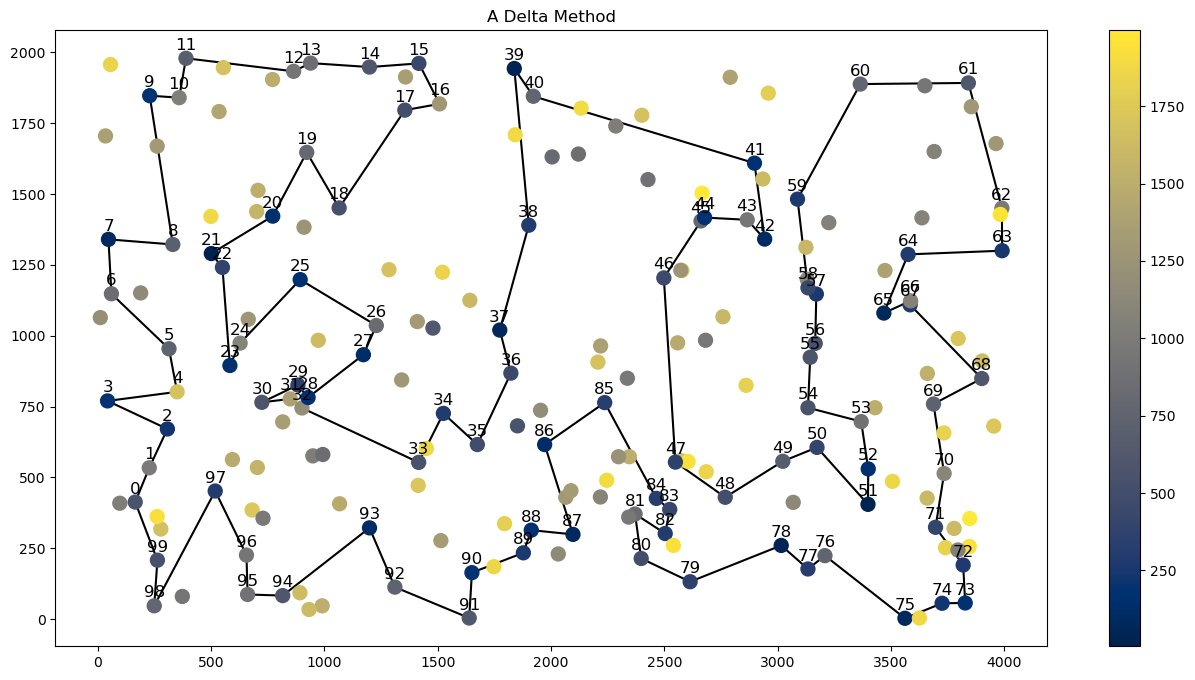

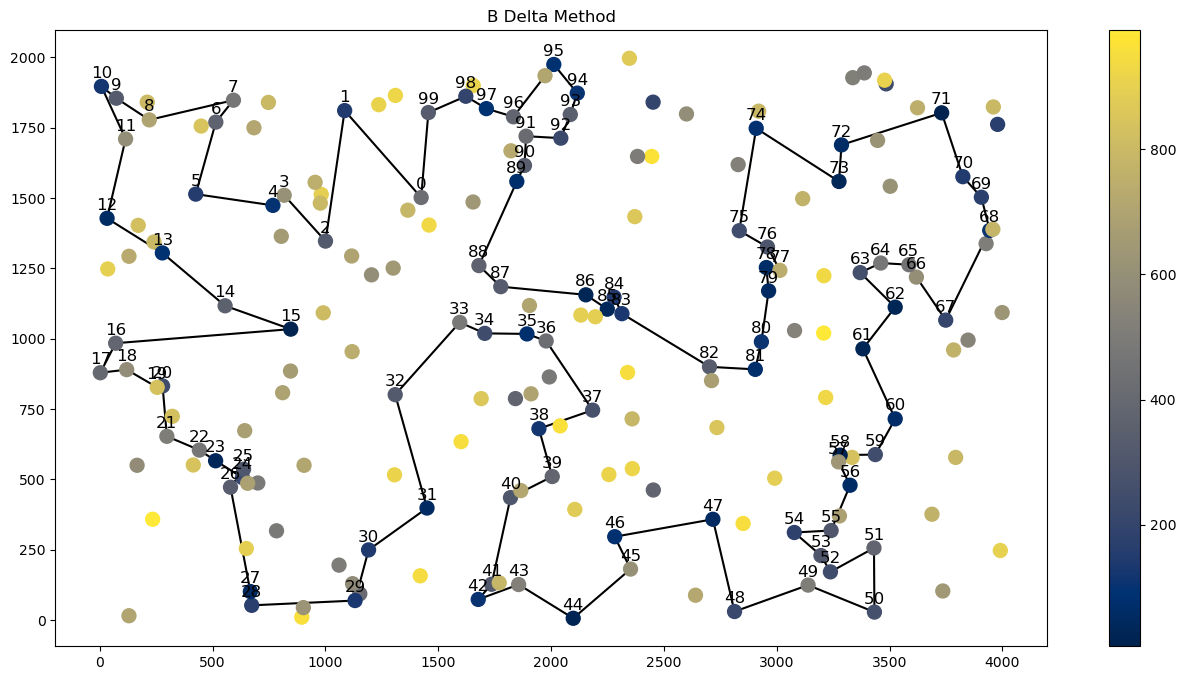

In [7]:
columns = []
experiments = []

for instance in (TspInstance("TSPA.csv"), TspInstance("TSPB.csv")):
    column = f"{instance.file_path[3]} Delta Method"
    columns.append(column)

    experiment = instance.run_experiments(delta_method)
    experiments.append(experiment)

    instance.plot(experiment[-1], column)

In [ ]:
import pandas as pd
pd.DataFrame(
    np.array(tuple(map(lambda x: x[:-1], experiments))).T,
    columns=columns,
    index=(
        "min_cost",
        "max_cost",
        "average_cost",
        "min_time",
        "max_time",
        "average_time",
    ),
)

### Previous Results

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A Candidate Edges Random</th>
      <th>B Candidate Edges Random</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>74938.000000</td>
      <td>47223.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>86066.000000</td>
      <td>52910.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>80740.440000</td>
      <td>49714.885000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.544722</td>
      <td>0.562735</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.817196</td>
      <td>0.727541</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.625702</td>
      <td>0.638483</td>
    </tr>
  </tbody>
</table>
</div>

### Current Results

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>A Delta Method</th>
      <th>B Delta Method</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>min_cost</th>
      <td>74571.000000</td>
      <td>46240.000000</td>
    </tr>
    <tr>
      <th>max_cost</th>
      <td>85281.000000</td>
      <td>53078.000000</td>
    </tr>
    <tr>
      <th>average_cost</th>
      <td>79310.945000</td>
      <td>49395.590000</td>
    </tr>
    <tr>
      <th>min_time</th>
      <td>0.175867</td>
      <td>0.224343</td>
    </tr>
    <tr>
      <th>max_time</th>
      <td>0.739338</td>
      <td>1.100046</td>
    </tr>
    <tr>
      <th>average_time</th>
      <td>0.373330</td>
      <td>0.469544</td>
    </tr>
  </tbody>
</table>
</div>

# Conclusions
- After applying delta method, we get slithly better results in regard to objective function value for basically each case except B maximum cost.
- The compilation time delta method was far better as expected, for minimum cases, it was 2/3 times better, but in average was significantly faster as well.

[Source code: https://github.com/krzychuszala/EC-TSP](https://github.com/krzychuszala/EC-TSP)